# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям 

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [2]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import tqdm
import copy
import torch.optim as optim

## Загрузка данных

In [6]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [7]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


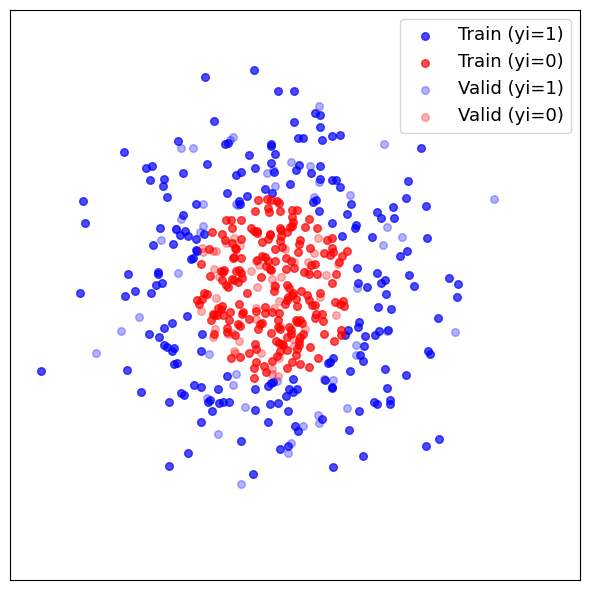

In [8]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть 

In [3]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
                        
    def forward(self, x):
        return self.layers(x)
    

##  Функция обучения сети

In [10]:
def start_train(
        model,      # model to train
        loss_fn,    # loss func
        opt,        # optimizer
        n_epochs,   # number of epochs 
        batch_size, # size of each batch
        X_train,    # train features
        y_train,    # train predictions
        X_val=None, # test features
        y_val=None, # test predictions
    ):
    
    # data_loader = DataLoader(dataset = TensorDataset(X_train, y_train), batch_size = batch_size)

    # x_val_ld = DataLoader(dataset = X_val, batch_size = 1) if X_val != None else None
    # y_val_ld = DataLoader(dataset = y_val, batch_size = 1) if y_val != None else None

    batch_start = torch.arange(start=0, end=len(X_train), step=batch_size)

    optimizer = opt
    
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    preds_history = []
    loss_history = []
    valid_acc_history = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            # for x, y in data_loader:
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch.reshape(batch_size, 1))
                loss_history.append(loss.item())

                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # update weights
                optimizer.step()
                
                # print progress
                acc = (y_pred.round() == y_batch.reshape(batch_size, 1)).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )    
    
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        
        if (epoch % 2 == 0):
            preds = np.where(model(X_val).detach().numpy().reshape(-1) > 0.5, 1, 0)
            preds_history.append(preds)
        
        acc = (y_pred.round() == y_val.reshape(len(y_val), 1)).float().mean()
        acc = float(acc)
        valid_acc_history.append(acc)

        print(f'Epoch {epoch} acc={acc}')
        
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.98:
            break
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return loss_history, preds_history, valid_acc_history

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [11]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

model_sgd_opt = NeuralNetwork()
model_adam_opt = NeuralNetwork()
model_rmsprop_opt = NeuralNetwork()

configurations = {
    'SGD': {
        'learning_rate': 0.1,
        'model': model_sgd_opt,
        'opt': optim.SGD,
    },
    'Adam': {
        'learning_rate': 0.01,
        'model': model_adam_opt,
        'opt': optim.Adam,
    },
    'RMSprop': {
        'learning_rate': 0.02,
        'model': model_rmsprop_opt,
        'opt': optim.RMSprop,
    }
}

result = {
    'SGD': {
        'loss_history': [],
        'predict_history': [],
        'valid_acc_history': []
    },
    'Adam': {
        'loss_history': [],
        'predict_history': [],
        'valid_acc_history': []
    },
    'RMSprop': {
        'loss_history': [],
        'predict_history': [],
        'valid_acc_history': []
    },
}

for conf_name, conf in configurations.items():
    print(conf_name)
    
    model = conf['model']
    optimizer = conf['opt'](model.parameters(), lr=conf['learning_rate'])
    
    loss_history, predict_history, valid_acc_history = start_train(
        model=model, 
        loss_fn=nn.BCELoss(), 
        opt=optimizer, 
        n_epochs=30, 
        batch_size=16,
        X_train=X_train_torch,
        y_train=y_train_torch,
        X_val=X_valid_torch, 
        y_val=y_valid_torch
    )
    
    result[conf_name]['loss_history'] = loss_history
    result[conf_name]['predict_history'] = predict_history
    result[conf_name]['valid_acc_history'] = valid_acc_history


SGD


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 281.78batch/s, acc=0.812, loss=0.619]


Epoch 0 acc=0.5199999809265137


Epoch 1: 100%|██████████| 25/25 [00:00<00:00, 491.84batch/s, acc=0.875, loss=0.578]


Epoch 1 acc=0.6600000262260437


Epoch 2: 100%|██████████| 25/25 [00:00<00:00, 491.83batch/s, acc=0.938, loss=0.544]


Epoch 2 acc=0.8199999928474426


Epoch 3: 100%|██████████| 25/25 [00:00<00:00, 533.67batch/s, acc=1, loss=0.511]    


Epoch 3 acc=0.8899999856948853


Epoch 4: 100%|██████████| 25/25 [00:00<00:00, 570.08batch/s, acc=1, loss=0.479]    


Epoch 4 acc=0.9399999976158142


Epoch 5: 100%|██████████| 25/25 [00:00<00:00, 482.38batch/s, acc=1, loss=0.449]    


Epoch 5 acc=0.9399999976158142


Epoch 6: 100%|██████████| 25/25 [00:00<00:00, 511.90batch/s, acc=1, loss=0.419]    


Epoch 6 acc=0.949999988079071


Epoch 7: 100%|██████████| 25/25 [00:00<00:00, 597.23batch/s, acc=1, loss=0.39]     


Epoch 7 acc=0.9599999785423279


Epoch 8: 100%|██████████| 25/25 [00:00<00:00, 464.51batch/s, acc=1, loss=0.362]    


Epoch 8 acc=0.9599999785423279


Epoch 9: 100%|██████████| 25/25 [00:00<00:00, 597.22batch/s, acc=1, loss=0.336]    


Epoch 9 acc=0.9599999785423279


Epoch 10: 100%|██████████| 25/25 [00:00<00:00, 501.67batch/s, acc=1, loss=0.312]    


Epoch 10 acc=0.9700000286102295


Epoch 11: 100%|██████████| 25/25 [00:00<00:00, 597.22batch/s, acc=1, loss=0.29]     


Epoch 11 acc=0.9700000286102295


Epoch 12: 100%|██████████| 25/25 [00:00<00:00, 464.51batch/s, acc=1, loss=0.27]     


Epoch 12 acc=0.9700000286102295


Epoch 13: 100%|██████████| 25/25 [00:00<00:00, 533.69batch/s, acc=1, loss=0.253]    


Epoch 13 acc=0.9700000286102295


Epoch 14: 100%|██████████| 25/25 [00:00<00:00, 611.81batch/s, acc=1, loss=0.237]    


Epoch 14 acc=0.9700000286102295


Epoch 15: 100%|██████████| 25/25 [00:00<00:00, 501.66batch/s, acc=1, loss=0.224]    


Epoch 15 acc=0.9700000286102295


Epoch 16: 100%|██████████| 25/25 [00:00<00:00, 618.96batch/s, acc=1, loss=0.212]    


Epoch 16 acc=0.9700000286102295


Epoch 17: 100%|██████████| 25/25 [00:00<00:00, 496.61batch/s, acc=1, loss=0.201]    


Epoch 17 acc=0.9700000286102295


Epoch 18: 100%|██████████| 25/25 [00:00<00:00, 533.70batch/s, acc=1, loss=0.192]    


Epoch 18 acc=0.9700000286102295


Epoch 19: 100%|██████████| 25/25 [00:00<00:00, 627.09batch/s, acc=1, loss=0.183]    


Epoch 19 acc=0.9700000286102295


Epoch 20: 100%|██████████| 25/25 [00:00<00:00, 611.78batch/s, acc=1, loss=0.175]    


Epoch 20 acc=0.9800000190734863
Adam


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 411.21batch/s, acc=0.812, loss=0.571]


Epoch 0 acc=0.8100000023841858


Epoch 1: 100%|██████████| 25/25 [00:00<00:00, 545.29batch/s, acc=1, loss=0.434]    


Epoch 1 acc=0.9599999785423279


Epoch 2: 100%|██████████| 25/25 [00:00<00:00, 557.40batch/s, acc=1, loss=0.313]    


Epoch 2 acc=0.9800000190734863
RMSprop


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 570.09batch/s, acc=1, loss=0.191]    


Epoch 0 acc=0.9200000166893005


Epoch 1: 100%|██████████| 25/25 [00:00<00:00, 473.28batch/s, acc=1, loss=0.117]    


Epoch 1 acc=0.9599999785423279


Epoch 2: 100%|██████████| 25/25 [00:00<00:00, 597.22batch/s, acc=1, loss=0.0889]   


Epoch 2 acc=0.949999988079071


Epoch 3: 100%|██████████| 25/25 [00:00<00:00, 597.23batch/s, acc=1, loss=0.0749]    


Epoch 3 acc=0.949999988079071


Epoch 4: 100%|██████████| 25/25 [00:00<00:00, 533.70batch/s, acc=1, loss=0.0669]    


Epoch 4 acc=0.949999988079071


Epoch 5: 100%|██████████| 25/25 [00:00<00:00, 511.91batch/s, acc=1, loss=0.0612]    


Epoch 5 acc=0.9599999785423279


Epoch 6: 100%|██████████| 25/25 [00:00<00:00, 611.79batch/s, acc=1, loss=0.0566]    


Epoch 6 acc=0.9599999785423279


Epoch 7: 100%|██████████| 25/25 [00:00<00:00, 611.82batch/s, acc=1, loss=0.0536]   


Epoch 7 acc=0.9700000286102295


Epoch 8: 100%|██████████| 25/25 [00:00<00:00, 570.08batch/s, acc=1, loss=0.0512]    


Epoch 8 acc=0.9700000286102295


Epoch 9: 100%|██████████| 25/25 [00:00<00:00, 545.30batch/s, acc=1, loss=0.0494]    


Epoch 9 acc=0.9700000286102295


Epoch 10: 100%|██████████| 25/25 [00:00<00:00, 611.80batch/s, acc=1, loss=0.047]     


Epoch 10 acc=0.9700000286102295


Epoch 11: 100%|██████████| 25/25 [00:00<00:00, 464.50batch/s, acc=1, loss=0.0454]    


Epoch 11 acc=0.9700000286102295


Epoch 12: 100%|██████████| 25/25 [00:00<00:00, 583.35batch/s, acc=1, loss=0.0438]    


Epoch 12 acc=0.9700000286102295


Epoch 13: 100%|██████████| 25/25 [00:00<00:00, 597.24batch/s, acc=1, loss=0.0414]    


Epoch 13 acc=0.9700000286102295


Epoch 14: 100%|██████████| 25/25 [00:00<00:00, 597.23batch/s, acc=1, loss=0.0404]    


Epoch 14 acc=0.9700000286102295


Epoch 15: 100%|██████████| 25/25 [00:00<00:00, 597.22batch/s, acc=1, loss=0.0386]    


Epoch 15 acc=0.9599999785423279


Epoch 16: 100%|██████████| 25/25 [00:00<00:00, 557.41batch/s, acc=1, loss=0.0375]    


Epoch 16 acc=0.9599999785423279


Epoch 17: 100%|██████████| 25/25 [00:00<00:00, 597.23batch/s, acc=1, loss=0.0363]    


Epoch 17 acc=0.9599999785423279


Epoch 18: 100%|██████████| 25/25 [00:00<00:00, 456.06batch/s, acc=1, loss=0.0351]    


Epoch 18 acc=0.9599999785423279


Epoch 19: 100%|██████████| 25/25 [00:00<00:00, 627.09batch/s, acc=1, loss=0.0342]    


Epoch 19 acc=0.9599999785423279


Epoch 20: 100%|██████████| 25/25 [00:00<00:00, 611.79batch/s, acc=1, loss=0.0335]    


Epoch 20 acc=0.9599999785423279


Epoch 21: 100%|██████████| 25/25 [00:00<00:00, 583.34batch/s, acc=1, loss=0.0338]    


Epoch 21 acc=0.9599999785423279


Epoch 22: 100%|██████████| 25/25 [00:00<00:00, 473.28batch/s, acc=1, loss=0.0329]    


Epoch 22 acc=0.9599999785423279


Epoch 23: 100%|██████████| 25/25 [00:00<00:00, 570.06batch/s, acc=1, loss=0.0311]    


Epoch 23 acc=0.9599999785423279


Epoch 24: 100%|██████████| 25/25 [00:00<00:00, 597.24batch/s, acc=1, loss=0.0335]    


Epoch 24 acc=0.9599999785423279


Epoch 25: 100%|██████████| 25/25 [00:00<00:00, 611.79batch/s, acc=1, loss=0.0315]    


Epoch 25 acc=0.9599999785423279


Epoch 26: 100%|██████████| 25/25 [00:00<00:00, 482.36batch/s, acc=1, loss=0.0289]    


Epoch 26 acc=0.9599999785423279


Epoch 27: 100%|██████████| 25/25 [00:00<00:00, 597.24batch/s, acc=1, loss=0.0312]    


Epoch 27 acc=0.9599999785423279


Epoch 28: 100%|██████████| 25/25 [00:00<00:00, 570.07batch/s, acc=1, loss=0.0294]    


Epoch 28 acc=0.9599999785423279


Epoch 29: 100%|██████████| 25/25 [00:00<00:00, 627.10batch/s, acc=1, loss=0.0272]    

Epoch 29 acc=0.9599999785423279


### А теперь посмотрим на графики лоссов

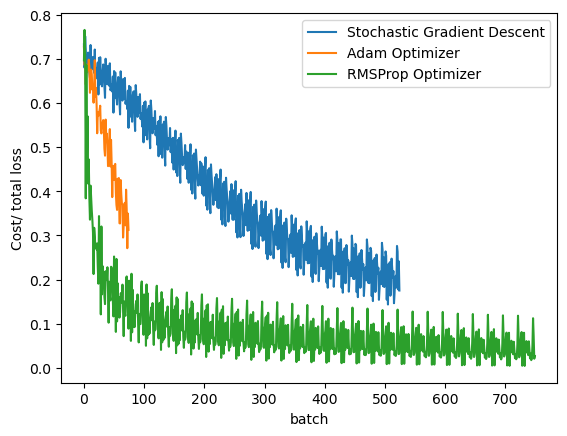

In [12]:
plt.plot(result['SGD']['loss_history'], label = "Stochastic Gradient Descent")
plt.plot(result['Adam']['loss_history'], label = "Adam Optimizer")
plt.plot(result['RMSprop']['loss_history'], label = 'RMSProp Optimizer')
plt.xlabel('batch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()


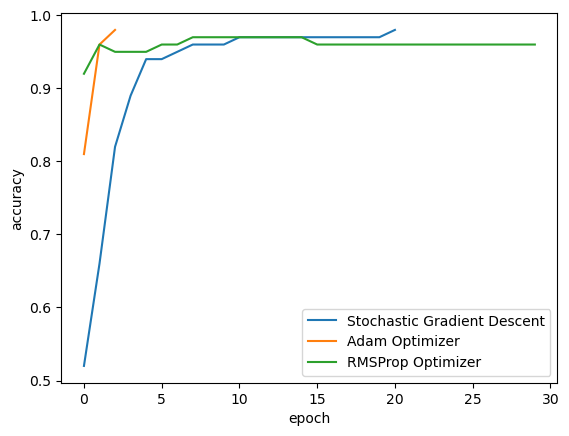

In [13]:
plt.plot(result['SGD']['valid_acc_history'], label = "Stochastic Gradient Descent")
plt.plot(result['Adam']['valid_acc_history'], label = "Adam Optimizer")
plt.plot(result['RMSprop']['valid_acc_history'], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните результат

In [14]:
from enum import Enum

class InitType(Enum):
    Random = 1
    Xavier = 2

class Net(nn.Module):
    def __init__(self, init_type: InitType) -> None:
        super(Net, self).__init__()
        
        self.layer_1 = nn.Linear(2, 32)
        self.act_1 = nn.LeakyReLU()
        
        self.out = nn.Linear(32, 1)
        self.sig = nn.Sigmoid()
        
        if init_type == InitType.Random:
            nn.init.normal_(self.layer_1.weight, mean=0, std=0.01)
            nn.init.normal_(self.layer_1.bias, mean=0, std=0.01)
            
            nn.init.normal_(self.out.weight, mean=0, std=0.01)
            nn.init.normal_(self.out.bias, mean=0, std=0.01)
        elif init_type == InitType.Xavier:
            nn.init.xavier_normal_(self.layer_1.weight)
            nn.init.zeros_(self.layer_1.bias)
            
            nn.init.xavier_normal_(self.out.weight)
            nn.init.zeros_(self.out.bias)
        
    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.sig(self.out(x))
        return x     

In [16]:
result = {}

for init_type in [InitType.Random, InitType.Xavier]:
    print(init_type)
    
    model = Net(init_type=init_type)
    optimizer = optim.SGD(model.parameters(), lr = 0.1)

    loss_history, _, _ = start_train(
            model=model, 
            loss_fn=nn.BCELoss(), 
            opt=optimizer, 
            n_epochs=100, 
            batch_size=16,
            X_train=X_train_torch,
            y_train=y_train_torch,
            X_val=X_valid_torch, 
            y_val=y_valid_torch
        )
    
    result[init_type] = loss_history


InitType.Random


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 716.69batch/s, acc=0.438, loss=0.693]


Epoch 0 acc=0.5099999904632568


Epoch 1: 100%|██████████| 25/25 [00:00<00:00, 447.91batch/s, acc=0.438, loss=0.693]


Epoch 1 acc=0.7200000286102295


Epoch 2: 100%|██████████| 25/25 [00:00<00:00, 611.79batch/s, acc=0.438, loss=0.693]


Epoch 2 acc=0.5299999713897705


Epoch 3: 100%|██████████| 25/25 [00:00<00:00, 473.26batch/s, acc=0.438, loss=0.693]


Epoch 3 acc=0.5400000214576721


Epoch 4: 100%|██████████| 25/25 [00:00<00:00, 491.84batch/s, acc=0.438, loss=0.693]


Epoch 4 acc=0.6200000047683716


Epoch 5: 100%|██████████| 25/25 [00:00<00:00, 482.38batch/s, acc=0.438, loss=0.692]


Epoch 5 acc=0.7099999785423279


Epoch 6: 100%|██████████| 25/25 [00:00<00:00, 522.57batch/s, acc=0.625, loss=0.691]


Epoch 6 acc=0.800000011920929


Epoch 7: 100%|██████████| 25/25 [00:00<00:00, 501.67batch/s, acc=0.688, loss=0.69] 


Epoch 7 acc=0.800000011920929


Epoch 8: 100%|██████████| 25/25 [00:00<00:00, 545.31batch/s, acc=0.875, loss=0.688]


Epoch 8 acc=0.8100000023841858


Epoch 9: 100%|██████████| 25/25 [00:00<00:00, 491.83batch/s, acc=0.938, loss=0.686]


Epoch 9 acc=0.8299999833106995


Epoch 10: 100%|██████████| 25/25 [00:00<00:00, 473.29batch/s, acc=0.938, loss=0.683]


Epoch 10 acc=0.8299999833106995


Epoch 11: 100%|██████████| 25/25 [00:00<00:00, 511.91batch/s, acc=0.938, loss=0.678]


Epoch 11 acc=0.8299999833106995


Epoch 12: 100%|██████████| 25/25 [00:00<00:00, 583.36batch/s, acc=0.938, loss=0.672]


Epoch 12 acc=0.8100000023841858


Epoch 13: 100%|██████████| 25/25 [00:00<00:00, 501.66batch/s, acc=0.938, loss=0.664]


Epoch 13 acc=0.8100000023841858


Epoch 14: 100%|██████████| 25/25 [00:00<00:00, 557.42batch/s, acc=0.938, loss=0.653]


Epoch 14 acc=0.8100000023841858


Epoch 15: 100%|██████████| 25/25 [00:00<00:00, 456.06batch/s, acc=0.938, loss=0.64] 


Epoch 15 acc=0.8199999928474426


Epoch 16: 100%|██████████| 25/25 [00:00<00:00, 570.09batch/s, acc=0.938, loss=0.623]


Epoch 16 acc=0.8199999928474426


Epoch 17: 100%|██████████| 25/25 [00:00<00:00, 522.56batch/s, acc=0.938, loss=0.604]


Epoch 17 acc=0.8199999928474426


Epoch 18: 100%|██████████| 25/25 [00:00<00:00, 557.42batch/s, acc=0.938, loss=0.583]


Epoch 18 acc=0.8100000023841858


Epoch 19: 100%|██████████| 25/25 [00:00<00:00, 583.32batch/s, acc=0.938, loss=0.56] 


Epoch 19 acc=0.8199999928474426


Epoch 20: 100%|██████████| 25/25 [00:00<00:00, 447.92batch/s, acc=0.938, loss=0.537]


Epoch 20 acc=0.8299999833106995


Epoch 21: 100%|██████████| 25/25 [00:00<00:00, 597.23batch/s, acc=0.938, loss=0.515]


Epoch 21 acc=0.8700000047683716


Epoch 22: 100%|██████████| 25/25 [00:00<00:00, 501.67batch/s, acc=0.938, loss=0.493]


Epoch 22 acc=0.8700000047683716


Epoch 23: 100%|██████████| 25/25 [00:00<00:00, 643.19batch/s, acc=0.938, loss=0.472]


Epoch 23 acc=0.8999999761581421


Epoch 24: 100%|██████████| 25/25 [00:00<00:00, 473.28batch/s, acc=0.938, loss=0.453]


Epoch 24 acc=0.9100000262260437


Epoch 25: 100%|██████████| 25/25 [00:00<00:00, 501.67batch/s, acc=1, loss=0.435]    


Epoch 25 acc=0.9300000071525574


Epoch 26: 100%|██████████| 25/25 [00:00<00:00, 533.72batch/s, acc=1, loss=0.416]    


Epoch 26 acc=0.9300000071525574


Epoch 27: 100%|██████████| 25/25 [00:00<00:00, 511.90batch/s, acc=1, loss=0.399]    


Epoch 27 acc=0.9399999976158142


Epoch 28: 100%|██████████| 25/25 [00:00<00:00, 511.92batch/s, acc=1, loss=0.381]    


Epoch 28 acc=0.9399999976158142


Epoch 29: 100%|██████████| 25/25 [00:00<00:00, 660.10batch/s, acc=1, loss=0.363]    


Epoch 29 acc=0.949999988079071


Epoch 30: 100%|██████████| 25/25 [00:00<00:00, 473.28batch/s, acc=1, loss=0.345]    


Epoch 30 acc=0.9700000286102295


Epoch 31: 100%|██████████| 25/25 [00:00<00:00, 611.80batch/s, acc=1, loss=0.328]    


Epoch 31 acc=0.9700000286102295


Epoch 32: 100%|██████████| 25/25 [00:00<00:00, 482.37batch/s, acc=1, loss=0.312]    


Epoch 32 acc=0.9800000190734863
InitType.Xavier


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 611.80batch/s, acc=0.812, loss=0.602]


Epoch 0 acc=0.800000011920929


Epoch 1: 100%|██████████| 25/25 [00:00<00:00, 501.67batch/s, acc=0.938, loss=0.564]


Epoch 1 acc=0.8199999928474426


Epoch 2: 100%|██████████| 25/25 [00:00<00:00, 643.18batch/s, acc=0.938, loss=0.535]


Epoch 2 acc=0.8799999952316284


Epoch 3: 100%|██████████| 25/25 [00:00<00:00, 502.95batch/s, acc=0.938, loss=0.508]


Epoch 3 acc=0.8999999761581421


Epoch 4: 100%|██████████| 25/25 [00:00<00:00, 627.08batch/s, acc=0.938, loss=0.482]


Epoch 4 acc=0.9200000166893005


Epoch 5: 100%|██████████| 25/25 [00:00<00:00, 660.08batch/s, acc=0.938, loss=0.458]


Epoch 5 acc=0.949999988079071


Epoch 6: 100%|██████████| 25/25 [00:00<00:00, 491.85batch/s, acc=0.938, loss=0.434]


Epoch 6 acc=0.949999988079071


Epoch 7: 100%|██████████| 25/25 [00:00<00:00, 643.17batch/s, acc=0.938, loss=0.41] 


Epoch 7 acc=0.949999988079071


Epoch 8: 100%|██████████| 25/25 [00:00<00:00, 491.83batch/s, acc=0.938, loss=0.387]


Epoch 8 acc=0.949999988079071


Epoch 9: 100%|██████████| 25/25 [00:00<00:00, 627.09batch/s, acc=1, loss=0.365]    


Epoch 9 acc=0.949999988079071


Epoch 10: 100%|██████████| 25/25 [00:00<00:00, 557.42batch/s, acc=1, loss=0.344]    


Epoch 10 acc=0.949999988079071


Epoch 11: 100%|██████████| 25/25 [00:00<00:00, 491.84batch/s, acc=1, loss=0.325]    


Epoch 11 acc=0.949999988079071


Epoch 12: 100%|██████████| 25/25 [00:00<00:00, 643.15batch/s, acc=1, loss=0.306]    


Epoch 12 acc=0.9599999785423279


Epoch 13: 100%|██████████| 25/25 [00:00<00:00, 491.83batch/s, acc=1, loss=0.289]    


Epoch 13 acc=0.9599999785423279


Epoch 14: 100%|██████████| 25/25 [00:00<00:00, 533.71batch/s, acc=1, loss=0.274]    


Epoch 14 acc=0.9599999785423279


Epoch 15: 100%|██████████| 25/25 [00:00<00:00, 473.27batch/s, acc=1, loss=0.26]     


Epoch 15 acc=0.9700000286102295


Epoch 16: 100%|██████████| 25/25 [00:00<00:00, 611.81batch/s, acc=1, loss=0.246]    


Epoch 16 acc=0.9700000286102295


Epoch 17: 100%|██████████| 25/25 [00:00<00:00, 511.91batch/s, acc=1, loss=0.235]    


Epoch 17 acc=0.9700000286102295


Epoch 18: 100%|██████████| 25/25 [00:00<00:00, 447.93batch/s, acc=1, loss=0.224]    


Epoch 18 acc=0.9700000286102295


Epoch 19: 100%|██████████| 25/25 [00:00<00:00, 643.15batch/s, acc=1, loss=0.214]    


Epoch 19 acc=0.9700000286102295


Epoch 20: 100%|██████████| 25/25 [00:00<00:00, 501.67batch/s, acc=1, loss=0.205]    


Epoch 20 acc=0.9700000286102295


Epoch 21: 100%|██████████| 25/25 [00:00<00:00, 597.22batch/s, acc=1, loss=0.196]    


Epoch 21 acc=0.9700000286102295


Epoch 22: 100%|██████████| 25/25 [00:00<00:00, 643.18batch/s, acc=1, loss=0.189]    


Epoch 22 acc=0.9700000286102295


Epoch 23: 100%|██████████| 25/25 [00:00<00:00, 501.67batch/s, acc=1, loss=0.181]    


Epoch 23 acc=0.9700000286102295


Epoch 24: 100%|██████████| 25/25 [00:00<00:00, 570.07batch/s, acc=1, loss=0.174]    


Epoch 24 acc=0.9700000286102295


Epoch 25: 100%|██████████| 25/25 [00:00<00:00, 522.61batch/s, acc=1, loss=0.168]    


Epoch 25 acc=0.9700000286102295


Epoch 26: 100%|██████████| 25/25 [00:00<00:00, 611.78batch/s, acc=1, loss=0.162]    


Epoch 26 acc=0.9700000286102295


Epoch 27: 100%|██████████| 25/25 [00:00<00:00, 627.08batch/s, acc=1, loss=0.157]    


Epoch 27 acc=0.9700000286102295


Epoch 28: 100%|██████████| 25/25 [00:00<00:00, 482.37batch/s, acc=1, loss=0.152]    


Epoch 28 acc=0.9700000286102295


Epoch 29: 100%|██████████| 25/25 [00:00<00:00, 627.07batch/s, acc=1, loss=0.147]    


Epoch 29 acc=0.9700000286102295


Epoch 30: 100%|██████████| 25/25 [00:00<00:00, 643.14batch/s, acc=1, loss=0.143]    


Epoch 30 acc=0.9700000286102295


Epoch 31: 100%|██████████| 25/25 [00:00<00:00, 482.39batch/s, acc=1, loss=0.138]    


Epoch 31 acc=0.9700000286102295


Epoch 32: 100%|██████████| 25/25 [00:00<00:00, 643.14batch/s, acc=1, loss=0.135]    


Epoch 32 acc=0.9700000286102295


Epoch 33: 100%|██████████| 25/25 [00:00<00:00, 491.84batch/s, acc=1, loss=0.131]    


Epoch 33 acc=0.9700000286102295


Epoch 34: 100%|██████████| 25/25 [00:00<00:00, 611.80batch/s, acc=1, loss=0.127]    


Epoch 34 acc=0.9700000286102295


Epoch 35: 100%|██████████| 25/25 [00:00<00:00, 627.08batch/s, acc=1, loss=0.124]    


Epoch 35 acc=0.9700000286102295


Epoch 36: 100%|██████████| 25/25 [00:00<00:00, 501.68batch/s, acc=1, loss=0.121]    


Epoch 36 acc=0.9700000286102295


Epoch 37: 100%|██████████| 25/25 [00:00<00:00, 545.31batch/s, acc=1, loss=0.118]    


Epoch 37 acc=0.9700000286102295


Epoch 38: 100%|██████████| 25/25 [00:00<00:00, 611.77batch/s, acc=1, loss=0.115]    


Epoch 38 acc=0.9700000286102295


Epoch 39: 100%|██████████| 25/25 [00:00<00:00, 473.29batch/s, acc=1, loss=0.113]    


Epoch 39 acc=0.9700000286102295


Epoch 40: 100%|██████████| 25/25 [00:00<00:00, 611.78batch/s, acc=1, loss=0.11]     


Epoch 40 acc=0.9700000286102295


Epoch 41: 100%|██████████| 25/25 [00:00<00:00, 482.38batch/s, acc=1, loss=0.108]    

Epoch 41 acc=0.9800000190734863


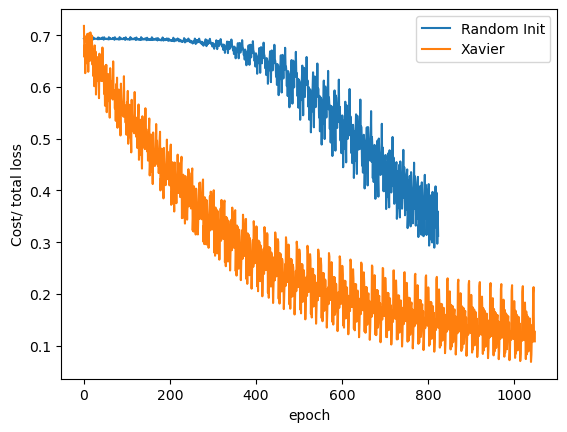

In [17]:
plt.plot(result[InitType.Random], label = "Random Init")
plt.plot(result[InitType.Xavier], label = "Xavier")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

Найдите лучшие параметры через KFold

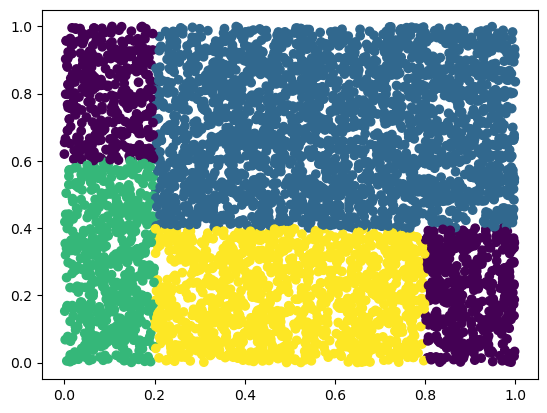

In [109]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)
        
target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [4]:
train

tensor([[0.8099, 0.1186, 0.0000],
        [0.6313, 0.8004, 1.0000],
        [0.7700, 0.6753, 1.0000],
        ...,
        [0.2416, 0.1706, 3.0000],
        [0.9639, 0.6826, 1.0000],
        [0.6791, 0.9508, 1.0000]])

In [211]:
class AdvancedModel(nn.Module):   
    def __init__(self,):
        super(AdvancedModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, 4),
        )
        
        for param in self.layers:
            self.init_parameter(param)
            
    def init_parameter(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.zeros_(module.bias)    
    
    def forward(self, x):
        return self.layers(x) 
        

In [37]:
# one hot example
labels=torch.Tensor([[0, 2, 1]]).long()
n_classes=3
indicies = torch.nn.functional.one_hot(labels, n_classes)
test_pred = torch.Tensor([[[0.99, 0, 0], [0,0,0.8], [0,0,0]]])

loss_fn = nn.CrossEntropyLoss()

loss_fn(test_pred.float(), indicies.float())


tensor(0.7652)

In [221]:
def train_model(
    model,      # model to train
    optim,      # optimizer
    loss_fn,    # loss function
    n_epochs,   # number of epochs 
    batch_size, # size of each batch
    X_train,    # train features
    y_train,    # train predictions
    X_val,      # test features
    y_val,      # test predictions
):
    if torch.cuda.is_available():
        X_val, y_val = X_val.cuda(), y_val.cuda()
        X_train, y_train = X_train.cuda(), y_train.cuda()
    
    # datasets
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_val, y_val)
    # getting DataLoader 
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)
    
    optimizer = optim
    
    loss_history = []
    acc_history = []
    
    best_acc = - np.inf
    best_weights = []

    total_correct = 0
    total_instances = 0
    
    total_loss = 0
    
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(train_loader, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x_train, y_train in bar:
                
                if torch.cuda.is_available():
                    x_train, y_train = x_train.cuda(), y_train.cuda()

                # forward
                y_pred = model(x_train)
     
                loss = loss_fn(y_pred, y_train)
                # appending loss to history
                total_loss+=loss.item()
                # clear the gradients
                optimizer.zero_grad()                
                # backward pass
                loss.backward() 
                # update weights
                optimizer.step()                
                # counting correct predictions
                correct_predictions = sum(torch.argmax(y_pred, dim=1) == y_train).item()
                # counting total predictions
                total_correct+=correct_predictions
                # counting total instances
                total_instances+=len(x_train)
                # counting accuracy of the model
                acc = round(total_correct/total_instances, 3)
                # print result to bar
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
                
        loss_history.append(round(total_loss/total_instances, 3))
        acc_history.append(round(total_correct/total_instances, 3))
        
        model.eval()
        
        val_total_correct = 0
        val_total_instances = 0
        
        acc = 0.0
        
        with tqdm.tqdm(valid_loader, unit="batch", mininterval=0, disable=False) as valid_bar:
            valid_bar.set_description("validation")

            for x_valid, y_valid in valid_bar:

                if torch.cuda.is_available():
                    x_valid, y_valid = x_valid.cuda(), y_valid.cuda()

                y_valid_pred = model(x_valid)
                
                correct_predictions = sum(torch.argmax(y_valid_pred, dim=1)==y_valid).item()
                
                val_total_correct += correct_predictions
                val_total_instances += len(x_valid)
                
                acc = round(val_total_correct/val_total_instances, 3)
                
                val_loss = loss_fn(y_valid_pred, y_valid)
                
                valid_bar.set_postfix(
                    loss=float(val_loss),
                    acc=float(acc),
                )
                
                if acc > best_acc:
                    best_acc = acc
                    best_weights = copy.deepcopy(model.state_dict())
                if acc > 0.98:
                    break
        
    model.load_state_dict(best_weights)
    return loss_history, acc_history, 
        

In [224]:
advanced_model = AdvancedModel()

if torch.cuda.is_available():
    advanced_model = advanced_model.cuda()
    
opt = optim.Adam(advanced_model.parameters(), lr=0.01)

lh, acc_h = train_model(
    model=advanced_model,
    optim=opt,
    loss_fn=nn.CrossEntropyLoss(),
    n_epochs=100,
    batch_size=32,
    X_train=train[:,:2],
    y_train=train[:,2].type(torch.LongTensor) ,
    X_val=valid[:,:2],
    y_val=valid[:,2].type(torch.LongTensor) 
)

validation:   0%|          | 0/4 [00:00<?, ?batch/s, acc=1, loss=0.0354]


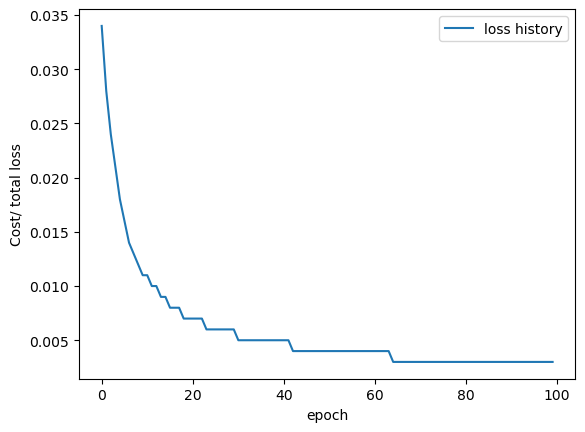

In [225]:
plt.plot(lh, label = "loss history")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

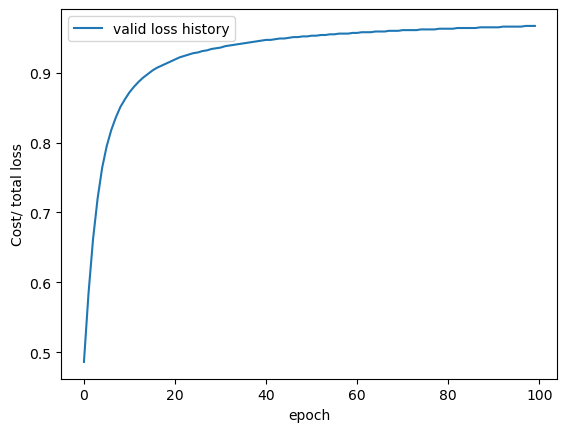

In [226]:
plt.plot(acc_h, label = "valid loss history")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

## (Почти) Боевая задача
 
Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [19]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.tail()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840.0,2
177,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560.0,2


In [60]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [62]:
X_train, y_train = df_train.drop(['target'], axis=1), df_train['target']
X_test, y_test = df_test.drop(['target'], axis=1), df_test['target']


In [63]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)

y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

In [64]:
df['target'].unique()

array([0, 1, 2])

In [24]:
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [27]:
X_train.columns.size

13

In [148]:
class AlcoholNet(nn.Module):
    def __init__(self, hidden_cnt):
        super().__init__()

        self.layers = nn.Sequential(
            # IN layer
            nn.Linear(13, hidden_cnt),
            nn.Sigmoid(),
            # HIDDEN layer 
            nn.Linear(hidden_cnt, hidden_cnt),
            nn.Sigmoid(),
            # OUT layer
            nn.Linear(hidden_cnt, 3),
        )
    
    def forward(self, x):
        return self.layers(x)

In [201]:
alcohol_net = AlcoholNet(100)

if torch.cuda.is_available():
    alcohol_net = alcohol_net.cuda()

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(alcohol_net.parameters(),lr=0.01)

batch_size = 32

In [202]:
lh, acc_h = train_model(
    model=alcohol_net,
    optim=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    n_epochs=500,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test
)

validation: 100%|██████████| 2/2 [00:00<00:00, 668.95batch/s, acc=0.972, loss=0.111]


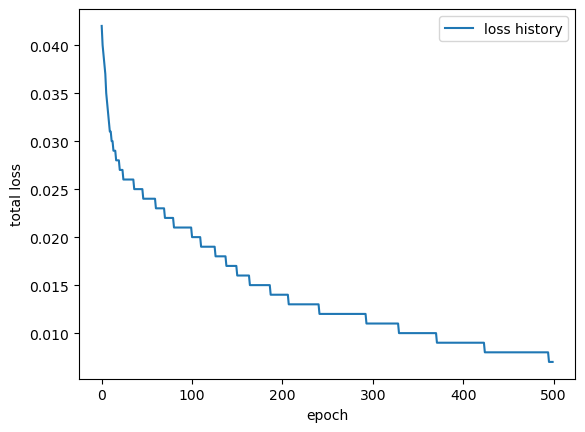

In [203]:
plt.plot(lh, label = "loss history")
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.legend()
plt.show()

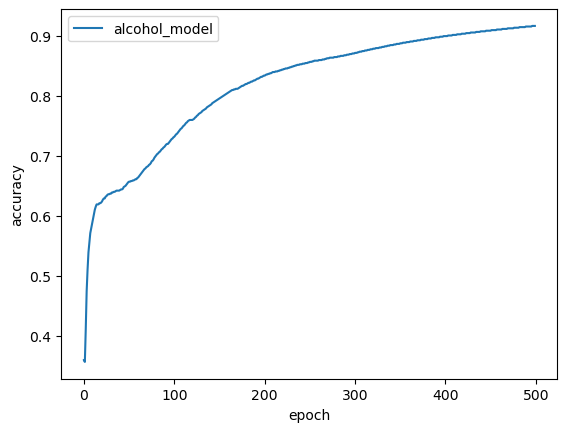

In [204]:
plt.plot(acc_h, label = "alcohol_model")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()